# Import Dataset

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
)
from sklearn.feature_selection import RFE

from Preprocessing_functions import *




In [4]:
train_data = pd.read_csv('train_data.csv', index_col='Claim Identifier')
test_data = pd.read_csv('test_data.csv', index_col='Claim Identifier')

/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_75084/3470921380.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('train_data.csv', index_col='Claim Identifier')


# Preprocessing

In [5]:
train_data = train_data[~(train_data.drop(columns=['Assembly Date']).isna().all(axis=1) & train_data['Assembly Date'].notna())]

In [6]:
X = train_data.drop(columns=['Claim Injury Type', 'WCB Decision', 'Agreement Reached'])
y = train_data['Claim Injury Type']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [64]:
y.isna().sum()

np.int64(0)

### column selection

In [8]:
CODE_COLUMNS = ['Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code']

DESCRIPTION_COLUMNS = ['WCIO Cause of Injury Description','WCIO Nature of Injury Description','WCIO Part Of Body Description','Industry Code Description']

BOOLEAN_COLUMNS = ['Alternative Dispute Resolution', 'Attorney/Representative','COVID-19 Indicator']

date_order = ['Accident Date', 'C-2 Date','C-3 Date','Assembly Date', 'First Hearing Date']


In [9]:
numerical_columns = [
    'Accident Date', 
    'Age at Injury', 
    'Assembly Date', 
    'Average Weekly Wage', 
    'Birth Year', 
    'C-2 Date', 
    'C-3 Date', 
    'First Hearing Date', 
    'IME-4 Count', 
]

outliers_columns = [
    'Accident Date', 
    'Age at Injury', 
    'Assembly Date', 
    'Average Weekly Wage', 
    'Birth Year',
    'IME-4 Count', 
]

categorical_features = ['Alternative Dispute Resolution',
 'Attorney/Representative',
 'Carrier Name',
 'Carrier Type',
 'County of Injury',
 'COVID-19 Indicator',
 'District Name',
 'Gender',
 'Industry Code',
 'Medical Fee Region',
 'WCIO Cause of Injury Code',
 'WCIO Nature of Injury Code',
 'WCIO Part Of Body Code',
 'Zip Code']

col_minmax = ['Age at Injury',
               'Birth Year', 
               'Number of Dependents']

col_standart = ['Accident Date',
                'Assembly Date',
                'Average Weekly Wage',
                ]

columns_to_drop = ['C-2 Date', 'C-3 Date', 'First Hearing Date']

low_cardinality_cols = [col for col in categorical_features if X_train[col].nunique() < 10]
high_cardinality_cols = [col for col in categorical_features if X_train[col].nunique() > 10]




### Preprocesing testing

In [10]:
def type_coversion_categorical(X_train, X_val):
    X_train[categorical_features] = X_train[categorical_features].astype(str)
    X_val[categorical_features] = X_val[categorical_features].astype(str)
    return X_train, X_val

In [11]:
def drop_description_columns(X_train, X_val):
    """
    Drop all columns in X_train and X_val that contain the word 'description' in their names (case-insensitive).
    """
    description_columns = X_train.columns[X_train.columns.str.contains('description', case=False, na=False)]
    

    X_train = X_train.drop(description_columns, axis=1)
    X_val = X_val.drop(description_columns, axis=1)
    
    return X_train, X_val

In [12]:
def unwanted_columns(X_train, X_val, columns):
    X_train = X_train.drop(columns, axis=1)
    X_val = X_val.drop(columns, axis=1)
    return X_train, X_val

In [13]:
def winsorize_outliers(X_train, X_val, columns):
    """
    Winsorizes outliers in the specified columns for X_train and X_val.
    The bounds are calculated based on the X_train data.
    """
    for column in columns:
        # Calculate bounds based on X_train
        q1 = X_train[column].quantile(0.25)
        q3 = X_train[column].quantile(0.75)
        iqr = q3 - q1

        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Winsorize the column in X_train
        X_train[column] = X_train[column].apply(
            lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x)
        )

        # Winsorize the column in X_val using the same bounds
        X_val[column] = X_val[column].apply(
            lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x)
        )

    return X_train, X_val

In [ ]:
def preprocessing_encoding_dum(X_train, X_val):
    X_train, X_val = type_coversion_categorical(X_train, X_val)
    X_train, X_val = drop_description_columns(X_train, X_val)
    X_train, X_val = convert_to_timestamp(X_train, X_val, date_order)
    X_train, X_val = convert_to_bool(X_train, X_val, col_names=BOOLEAN_COLUMNS)
    X_train, X_val = impute_mean_numerical(X_train, X_val, numerical_columns)
    X_train, X_val = fill_missing_with_mode(X_train, X_val)
    X_train, X_val = feature_creation_has_Cdate(X_train, X_val)
    X_train, X_val = unwanted_columns(X_train, X_val, columns_to_drop)
    X_train, X_val = encoding_onehot(X_train, X_val, low_cardinality_cols)
    X_train, X_val = encoding_frequency1(X_train, X_val, high_cardinality_cols)
    return X_train, X_val

def preprocessing_scaling_encoding_dum(X_train, X_val):
    X_train, X_val = type_coversion_categorical(X_train, X_val)
    X_train, X_val = drop_description_columns(X_train, X_val)
    X_train, X_val = convert_to_timestamp(X_train, X_val, date_order)
    X_train, X_val = convert_to_bool(X_train, X_val, col_names=BOOLEAN_COLUMNS)
    X_train, X_val = impute_mean_numerical(X_train, X_val, numerical_columns)
    X_train, X_val = fill_missing_with_mode(X_train, X_val)
    X_train, X_val = feature_creation_has_Cdate(X_train, X_val)
    X_train, X_val = unwanted_columns(X_train, X_val, columns_to_drop)
    X_train, X_val = winsorize_outliers(X_train, X_val, outliers_columns)
    X_train, X_val = scaling_minmax(X_train, X_val, col_minmax)
    X_train, X_val = scaling_standard(X_train, X_val, col_standart)
    X_train, X_val = encoding_onehot(X_train, X_val, low_cardinality_cols)
    X_train, X_val = encoding_frequency1(X_train, X_val, high_cardinality_cols)
    return X_train, X_val

X_train, X_val = preprocessing_scaling_encoding_dum(X_train, X_val)

y_train, y_val = encoding_label(y_train, y_val)

X_train.info()


/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_75084/3507681993.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[categorical_features] = X_train[categorical_features].astype(str)
/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_75084/3507681993.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[categorical_features] = X_val[categorical_features].astype(str)
/Users/philippedutranoit/document ordi/nova/machine learning /project/ML_Group36/src/Preprocessing_functions.py:

<class 'pandas.core.frame.DataFrame'>
Index: 459220 entries, 0 to 574024
Data columns (total 49 columns):
 #   Column                                                    Non-Null Count   Dtype  
---  ------                                                    --------------   -----  
 0   Accident Date                                             459220 non-null  float64
 1   Age at Injury                                             459220 non-null  float64
 2   Assembly Date                                             459220 non-null  float64
 3   Average Weekly Wage                                       459220 non-null  float64
 4   Birth Year                                                459220 non-null  float64
 5   IME-4 Count                                               459220 non-null  float64
 6   Number of Dependents                                      459220 non-null  float64
 7   Has C-3 Date                                              459220 non-null  int64  
 8   Has C-2 D

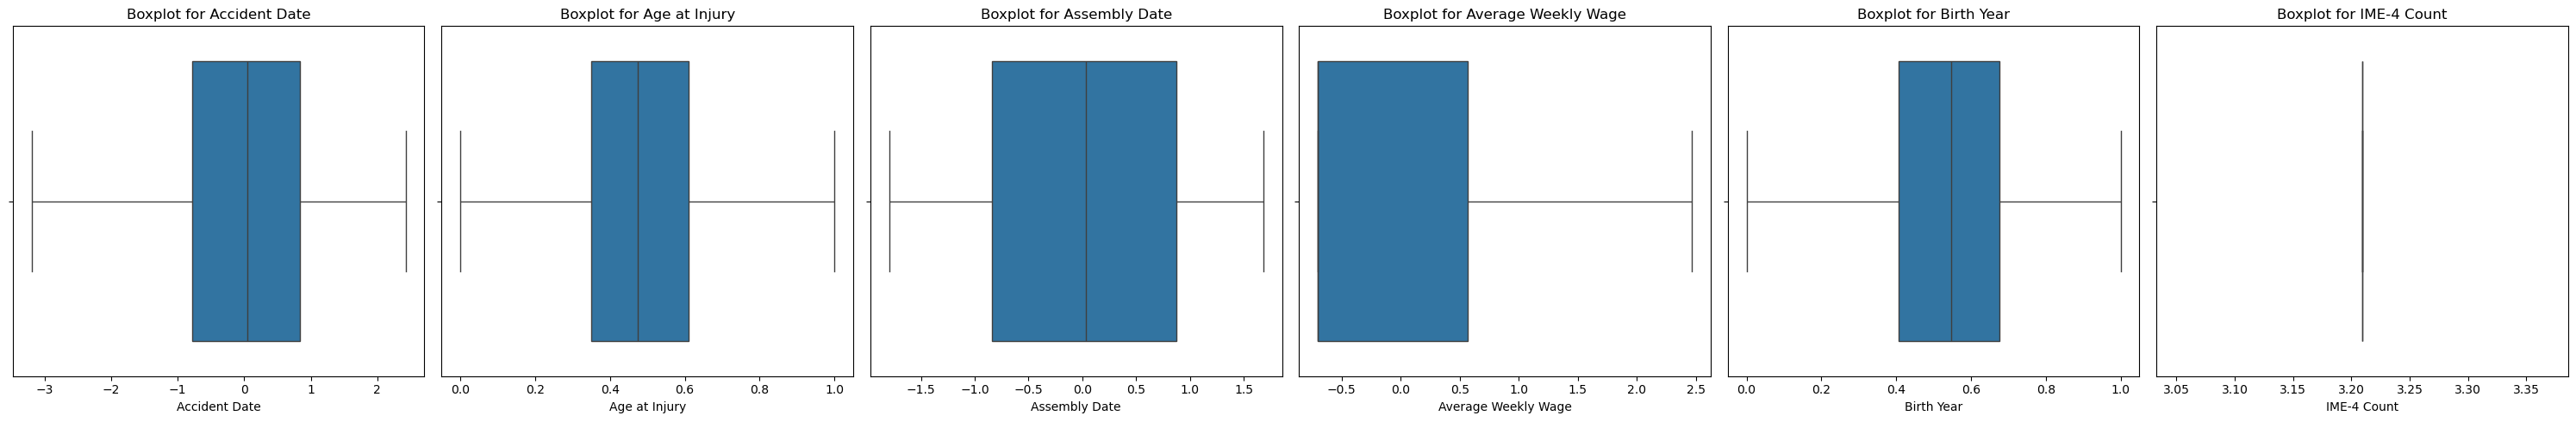

In [72]:
def plot_boxplots(df, columns):
    """
    Plots box plots for a list of columns in the given DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    columns (list): The list of column names to plot.

    Returns:
    None
    """
    num_columns = len(columns)
    fig, axes = plt.subplots(1, num_columns, figsize=(5 * num_columns, 5))

    # Ensure axes is iterable even for one column
    if num_columns == 1:
        axes = [axes]

    for ax, column in zip(axes, columns):
        sns.boxplot(data=df, x=column, ax=ax)
        ax.set_title(f'Boxplot for {column}')

    plt.tight_layout()
    plt.show()

# Example usage
plot_boxplots(X_train, outliers_columns)


In [73]:

"""
def preprocessing_complex(X_train, X_val):
    convert_to_timestamp(X_train, X_val, date_order)
    convert_to_bool(X_train, X_val, col_names=BOOLEAN_COLUMNS)
    impute_mean_numerical(X_train, X_val, ['C-2 Date'])
    fillna_zip_code(X_train, X_val)
    fillnan_accident_date(X_train,X_val)
    fillnan_birth_year(X_train,X_val)
    feature_creation_has_Cdate (X_train, X_val)
    fill_missing_with_mode(X_train, X_val)
    drop_description_columns(X_train, X_val)
    scaling_standard(X_train, X_val, columns)
    encoding_onehot(X_train, X_val, columns)
    return X_train, X_val
preprocessing_complex(X_train, X_val)

X_train.info()
"""

"\ndef preprocessing_complex(X_train, X_val):\n    convert_to_timestamp(X_train, X_val, date_order)\n    convert_to_bool(X_train, X_val, col_names=BOOLEAN_COLUMNS)\n    impute_mean_numerical(X_train, X_val, ['C-2 Date'])\n    fillna_zip_code(X_train, X_val)\n    fillnan_accident_date(X_train,X_val)\n    fillnan_birth_year(X_train,X_val)\n    feature_creation_has_Cdate (X_train, X_val)\n    fill_missing_with_mode(X_train, X_val)\n    drop_description_columns(X_train, X_val)\n    scaling_standard(X_train, X_val, columns)\n    encoding_onehot(X_train, X_val, columns)\n    return X_train, X_val\npreprocessing_complex(X_train, X_val)\n\nX_train.info()\n"

# Model Training

#### Perform a first RFE to select our best K

In [74]:
# X_train_selected, selected_features, feature_ranking = feature_selection_rfe(X_train, y_train, 10, LogisticRegression(max_iter=1000))

In [75]:
feature_ranking

,Feature,Ranking
24,COVID-19 Indicator_True,1
47,WCIO Part Of Body Code,1
10,Alternative Dispute Resolution_False,1
43,County of Injury,1
44,Industry Code,1
45,WCIO Cause of Injury Code,1
13,Attorney/Representative_False,1
3,Average Weekly Wage,1
1,Age at Injury,1
46,WCIO Nature of Injury Code,1


In [76]:
features = [
    "COVID-19 Indicator_True",
    "WCIO Part Of Body Code",
    "Alternative Dispute Resolution_False",
    "County of Injury",
    "Industry Code",
    "WCIO Cause of Injury Code",
    "Attorney/Representative_False",
    "Average Weekly Wage",
    "Age at Injury",
    "WCIO Nature of Injury Code",
    "Carrier Name",
    "Carrier Type_2A. SIF",
    "Carrier Type_UNKNOWN",
    "COVID-19 Indicator_False",
    "Alternative Dispute Resolution_True",
    "IME-4 Count",
    "Attorney/Representative_True",
    "Birth Year",
    "Carrier Type_3A. SELF PUBLIC",
    "District Name_STATEWIDE",
    "District Name_NYC",
    "District Name_HAUPPAUGE",
    "Gender_F",
    "Carrier Type_5D. SPECIAL FUND - UNKNOWN",
    "Gender_X",
    "Carrier Type_4A. SELF PRIVATE",
    "Carrier Type_1A. PRIVATE",
    "Assembly Date",
    "Accident Date",
    "District Name_ROCHESTER",
    "District Name_BUFFALO",
    "Gender_M",
    "Has First Hearing Date",
    "Medical Fee Region_II",
    "District Name_BINGHAMTON",
    "District Name_SYRACUSE",
    "Has C-2 Date",
    "Has C-3 Date",
    "Medical Fee Region_UK",
    "Gender_U",
    "Medical Fee Region_III",
    "Medical Fee Region_IV",
    "Carrier Type_5A. SPECIAL FUND - CONS. COMM.",
    "Zip Code",
    "District Name_ALBANY",
    "Carrier Type_5C. SPECIAL FUND - POI CARRIER WC...",
    "Number of Dependents",
    "Medical Fee Region_I",
    "Alternative Dispute Resolution_nan"
]

In [77]:
selected_features

['COVID-19 Indicator_True',
 'WCIO Part Of Body Code',
 'Alternative Dispute Resolution_False',
 'County of Injury',
 'Industry Code',
 'WCIO Cause of Injury Code',
 'Attorney/Representative_False',
 'Average Weekly Wage',
 'Age at Injury',
 'WCIO Nature of Injury Code']

In [78]:
best_20_features = ['COVID-19 Indicator_True', 'WCIO Part Of Body Code', 'Alternative Dispute Resolution_False', 
 'County of Injury', 'Industry Code', 'WCIO Cause of Injury Code', 
 'Attorney/Representative_False', 'Average Weekly Wage', 'Age at Injury', 
 'WCIO Nature of Injury Code', 'Carrier Name', 'Carrier Type_2A. SIF', 
 'Carrier Type_UNKNOWN', 'COVID-19 Indicator_False', 
 'Alternative Dispute Resolution_True', 'IME-4 Count', 
 'Attorney/Representative_True', 'Birth Year', 
 'Carrier Type_3A. SELF PUBLIC', 'District Name_STATEWIDE', 
 'District Name_NYC', 'District Name_HAUPPAUGE', 'Gender_F']

In [15]:
best_10_features = ['COVID-19 Indicator_True', 'WCIO Part Of Body Code', 'Alternative Dispute Resolution_False', 
 'County of Injury', 'Industry Code', 'WCIO Cause of Injury Code', 
 'Attorney/Representative_False', 'Average Weekly Wage', 'Age at Injury', 
 'WCIO Nature of Injury Code']

#### Run the model with the selected feature to find the best K

The best k value is: 4
The best F1-score (macro) is: 0.3198395188981392


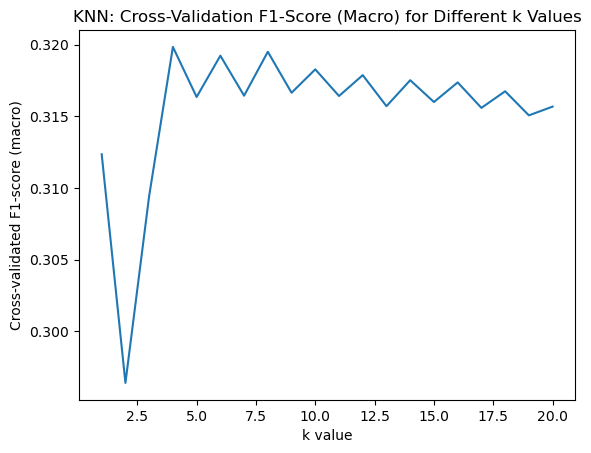

In [80]:
k_range = range(1, 21)
f1_scores = []

best_k = None
best_f1_score = -np.inf

for k in k_range:
    model = KNeighborsClassifier(n_neighbors=k)
    
    f1_scorer = make_scorer(f1_score, average='macro')
    
    cv_scores = cross_val_score(model, X_train[selected_features], y_train, cv=5, scoring = f1_scorer)
    mean_f1_score = np.mean(cv_scores)
    f1_scores.append(mean_f1_score)
    
    if mean_f1_score > best_f1_score:
        best_f1_score = mean_f1_score
        best_k = k

# Print the best k value
print(f"The best k value is: {best_k}")
print(f"The best F1-score (macro) is: {best_f1_score}")

# Plot the F1 scores
plt.plot(k_range, f1_scores)
plt.xlabel('k value')
plt.ylabel('Cross-validated F1-score (macro)')
plt.title('KNN: Cross-Validation F1-Score (Macro) for Different k Values')
plt.show()


The best k value is: None
The best F1-score (macro) is: 0.3168205057328396


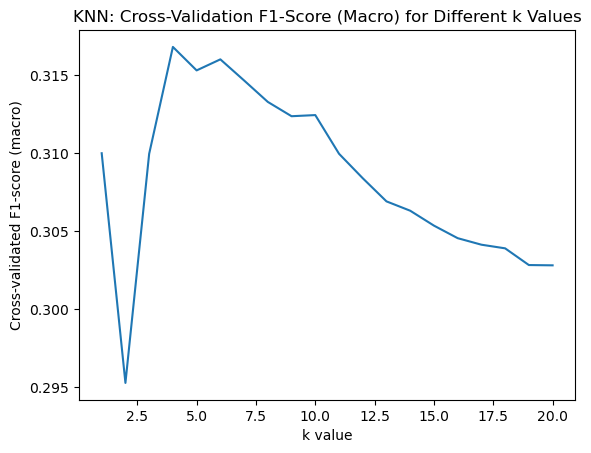

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, f1_score

k_range = range(1, 21)
f1_scores = []

best_k = None
best_f1_score = -np.inf

for k in k_range:
    model = KNeighborsClassifier(n_neighbors=k)
    
    f1_scorer = make_scorer(f1_score, average='macro')
    
    cv_scores = cross_val_score(model, X_train[best_20_features], y_train, cv=5, scoring = f1_scorer)
    mean_f1_score = np.mean(cv_scores)
    f1_scores.append(mean_f1_score)
    
    if mean_f1_score > best_f1_score:
        best_f1_score = mean_f1_score
        best_k_20 = k

# Print the best k value
print(f"The best k value is: {best_k}")
print(f"The best F1-score (macro) is: {best_f1_score}")

# Plot the F1 scores
plt.plot(k_range, f1_scores)
plt.xlabel('k value')
plt.ylabel('Cross-validated F1-score (macro)')
plt.title('KNN: Cross-Validation F1-Score (Macro) for Different k Values')
plt.show()

#### Run the model using K-fold and the K selected

In [82]:
X = X.reset_index(drop=True) 
y = y.reset_index(drop=True)

k = 4
n_splits = 5

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

accuracies = []
f1_scores = []

for train_index, val_index in kf.split(X_train):

    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    y_train, y_val = encoding_label(y_train, y_val)
    X_train, X_val = preprocessing_scaling_encoding_dum(X_train, X_val)


    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train[best_10_features], y_train)
    
    y_pred = model.predict(X_val[best_10_features])
    
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='macro')
    
    accuracies.append(accuracy)
    f1_scores.append(f1)

mean_accuracy = np.mean(accuracies)
mean_f1_score = np.mean(f1_scores)

print(f"Average accuracy with k={k} across {n_splits}-fold cross-validation: {mean_accuracy}")
print(f"Average F1-score (macro) with k={k} across {n_splits}-fold cross-validation: {mean_f1_score}")

# Print the accuracy and F1-score matrix
print("\nAccuracy Matrix:")
for i in range(n_splits):
    print(f"Fold {i+1} - Accuracy: {accuracies[i]}, F1-score (macro): {f1_scores[i]}")

/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_59723/3507681993.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[categorical_features] = X_train[categorical_features].astype(str)
/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_59723/3507681993.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[categorical_features] = X_val[categorical_features].astype(str)
/Users/philippedutranoit/document ordi/nova/machine learning /project/ML_Group36/src/Preprocessing_functions.py:

Average accuracy with k=4 across 5-fold cross-validation: 0.7190192064805541
Average F1-score (macro) with k=4 across 5-fold cross-validation: 0.318392959725736

Accuracy Matrix:
Fold 1 - Accuracy: 0.7217673446278472, F1-score (macro): 0.3180825795847403
Fold 2 - Accuracy: 0.7172379251774749, F1-score (macro): 0.31955977148396825
Fold 3 - Accuracy: 0.7198728278385088, F1-score (macro): 0.3189196962943365
Fold 4 - Accuracy: 0.7159858020121075, F1-score (macro): 0.3153023826843467
Fold 5 - Accuracy: 0.7202321327468316, F1-score (macro): 0.3201003685812881


In [83]:
X = X.reset_index(drop=True) 
y = y.reset_index(drop=True)

k = best_k_20
n_splits = 5

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

accuracies = []
f1_scores = []

for train_index, val_index in kf.split(X_train):

    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    y_train, y_val = encoding_label(y_train, y_val)
    X_train, X_val = preprocessing_scaling_encoding_dum(X_train, X_val)


    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train[best_20_features], y_train)
    
    y_pred = model.predict(X_val[best_20_features])
    
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='macro')
    
    accuracies.append(accuracy)
    f1_scores.append(f1)

mean_accuracy = np.mean(accuracies)
mean_f1_score = np.mean(f1_scores)

print(f"Average accuracy with k={k} across {n_splits}-fold cross-validation: {mean_accuracy}")
print(f"Average F1-score (macro) with k={k} across {n_splits}-fold cross-validation: {mean_f1_score}")

# Print the accuracy and F1-score matrix
print("\nAccuracy Matrix:")
for i in range(n_splits):
    print(f"Fold {i+1} - Accuracy: {accuracies[i]}, F1-score (macro): {f1_scores[i]}")

/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_59723/3507681993.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[categorical_features] = X_train[categorical_features].astype(str)
/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_59723/3507681993.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[categorical_features] = X_val[categorical_features].astype(str)
/Users/philippedutranoit/document ordi/nova/machine learning /project/ML_Group36/src/Preprocessing_functions.py:

Average accuracy with k=4 across 5-fold cross-validation: 0.7161817855507594
Average F1-score (macro) with k=4 across 5-fold cross-validation: 0.3179905159028344

Accuracy Matrix:
Fold 1 - Accuracy: 0.7165332897816974, F1-score (macro): 0.31384130993104525
Fold 2 - Accuracy: 0.7165838720653284, F1-score (macro): 0.3185310609911934
Fold 3 - Accuracy: 0.7170738346376319, F1-score (macro): 0.3163187284191557
Fold 4 - Accuracy: 0.7134263354882613, F1-score (macro): 0.31748131438116006
Fold 5 - Accuracy: 0.7172915957808779, F1-score (macro): 0.32378016579161745


In [ ]:

X = X.reset_index(drop=True) 
y = y.reset_index(drop=True)

learning_rate_range = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7]
kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies_mean = []
f1_scores_mean = []


for learning_rate in learning_rate_range:
    accuracies = []
    f1_scores = []
    for train_index, test_index in kf.split(X):

        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]

        y_train, y_val = encoding_label(y_train, y_val)
        X_train, X_val = preprocessing_encoding_dum(X_train, X_val)
        
        model = XGBClassifier(n_estimators=500, learning_rate= learning_rate_range, max_depth=6, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective='multi:softprob', n_jobs=-1)

        model.fit(X_train, y_train)
        
        # Evaluate on the test set
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')
    
        accuracies.append(accuracy)
        f1_scores.append(f1)
    
    # Compute the mean accuracy for this learning rate
    accuracies_mean.append(np.mean(accuracies))
    f1_scores_mean.append(np.mean(f1_scores))

# Find the optimal learning rate
optimal_lr = learning_rate_range[np.argmax(accuracies_mean)]
print(f"The optimal learning rate for accuracy is {optimal_lr}.")
optimal_lr = learning_rate_range[np.argmax(f1_scores_mean)]
print(f"The optimal learning rate for f1 score is {optimal_lr}.")

# Plot the results
plt.plot(learning_rate_range, f1_scores_mean)
plt.xlabel('Learning Rate')
plt.ylabel('f1_scores_mean')
plt.title('Optimal Learning Rate Selection using K-Fold Cross-Validation (XGBoost)')
plt.show()

plt.plot(learning_rate_range, accuracies_mean)
plt.xlabel('Learning Rate')
plt.ylabel('Mean Accuracy')
plt.title('Optimal Learning Rate Selection using K-Fold Cross-Validation (XGBoost)')
plt.show()



/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_75084/3507681993.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[categorical_features] = X_train[categorical_features].astype(str)
/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_75084/3507681993.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[categorical_features] = X_val[categorical_features].astype(str)
/Users/philippedutranoit/document ordi/nova/machine learning /project/ML_Group36/src/Preprocessing_functions.py:

KeyboardInterrupt: 